In [1]:
import pickle
import numpy as np
import pandas as pd

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics.pairwise import pairwise_distances

import os
os.chdir('../../')
from clustering_evaluation import ClusterPurity
evaluator=ClusterPurity()

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn

[nltk_data] Downloading package wordnet to /home/daikiri/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing:

### Load pre-trained RotatE Embedding Model on WN18RR Dataset:

In [4]:
PATH_TRANS_E = 'Dataset/wn18RR/rotate_wn18rr.pkl'
# transe_fb15k-237.pkl: pre-trained model of fb15k with 1024 dim.
with open(PATH_TRANS_E, "rb") as fin:
    model = pickle.load(fin)
    
entity2id = model.graph.entity2id
relation2id = model.graph.relation2id

entity_embeddings = model.solver.entity_embeddings
relation_embeddings = model.solver.relation_embeddings

entity_embeddings.shape

(40559, 256)

## Extract ground-truth from WN18RR Dataset:

In [5]:
syns = list(wn.all_synsets())
offsets_list = [(s.offset(), s) for s in syns]
offsets_dict = dict(offsets_list)

entityTypes={}
for entID in entity2id.keys():
    entity=offsets_dict[int(entID)]
    entityTypes[entID]=entity.lexname().split('.')[1]
    
# count frequent types in ground_truth
from collections import Counter
Counter(entityTypes.values()).most_common()    

[('plant', 4272),
 ('animal', 4023),
 ('person', 3686),
 ('artifact', 3582),
 ('act', 3034),
 ('communication', 2925),
 ('location', 1629),
 ('cognition', 1612),
 ('change', 1265),
 ('body', 1192),
 ('attribute', 1162),
 ('contact', 1116),
 ('group', 1043),
 ('state', 1010),
 ('all', 788),
 ('motion', 734),
 ('possession', 724),
 ('substance', 712),
 ('food', 677),
 ('social', 661),
 ('object', 568),
 ('event', 463),
 ('creation', 426),
 ('stative', 396),
 ('time', 381),
 ('quantity', 325),
 ('process', 312),
 ('pert', 301),
 ('perception', 257),
 ('competition', 230),
 ('emotion', 216),
 ('phenomenon', 195),
 ('feeling', 186),
 ('consumption', 139),
 ('shape', 117),
 ('relation', 103),
 ('weather', 41),
 ('Tops', 39),
 ('motive', 16),
 ('ppl', 1)]

In [7]:
#filter top commen types
entity_embedding_filter=[]
y_true_filter=[]

top_types=['plant', 'animal', 'person','food', 'communication']

for k, value in entityTypes.items():
    if value in top_types:        
        entity_embedding_filter.append(entity_embeddings[entity2id[k]])
        y_true_filter.append(value)
        
X_all = np.asarray(entity_embedding_filter)
X_all.shape        

(15583, 256)

### Encode the types as One-hot:

In [8]:
encoder = LabelEncoder()
y_all = encoder.fit_transform(y_true_filter)
labels = encoder.classes_.tolist()

# t-SNE Freebase visualization of RotatE Embedding in WN18RR Dataset

In [9]:
X_2d = TSNE(random_state=42).fit_transform(X_all)

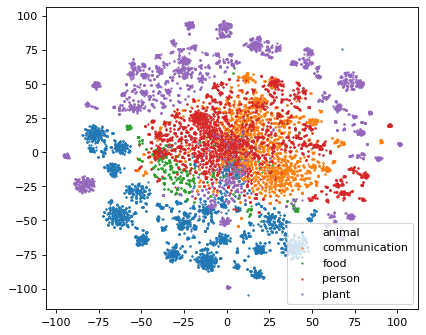

In [11]:
plt.figure(figsize=(6, 5), dpi=80)

label_ids = range(len(labels))
#colors = ['r', 'g', 'b', 'c', 'm', 'y']
colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']

for i, c, label in zip(label_ids, colors, labels):    
    plt.scatter(X_2d[y_all == i, 0], X_2d[y_all == i, 1], c=c, label=label, s=1)
    
plt.legend()    
plt.savefig('./Experiments/WN18RR/Figures/wn18RR-rotatE-full.png', dpi=600,  bbox_inches='tight',pad_inches=0)
plt.show()

# Unsupervisied Entity Typing:

## Method 1) HDBSCAN

In [12]:
import hdbscan

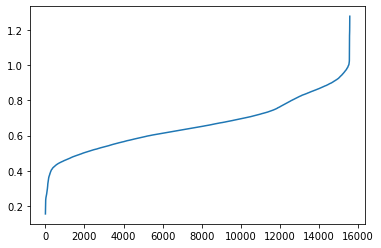

In [16]:
# final optimal value for cluster epsilon
neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(X_all)
distances, indices = nbrs.kneighbors(X_all)

distances = np.sort(distances, axis=0)
distances = distances[:,-1]
plt.plot(distances)

In [13]:
%%time
X_all_double=X_all.astype(np.double)
hdbscan_clusterer=hdbscan.HDBSCAN(algorithm='best', alpha=0.1, metric='precomputed',
                                   min_cluster_size=200, core_dist_n_jobs=-1, cluster_selection_epsilon=1.0)

distance_matrix = pairwise_distances(X_all_double, metric='cosine')
hdbscan_clusterer.fit(distance_matrix)

y_hdbscan=hdbscan_clusterer.labels_

# majority voting per cluster
df_tmp = pd.DataFrame({'pred_hdbscan': y_hdbscan, 'y_all': y_all})
pred_hdbscan = df_tmp.groupby('pred_hdbscan').transform(lambda x: x.mode().iloc[0]).to_numpy().reshape(-1)


CPU times: user 13.4 s, sys: 8.75 s, total: 22.1 s
Wall time: 15.7 s


In [14]:

accuracy = accuracy_score(y_all, pred_hdbscan)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_all, pred_hdbscan, zero_division=0, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_all, pred_hdbscan, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_all, pred_hdbscan, average='weighted')
print('F1 score: %f' % f1)

print ('Purity: ' , evaluator.purity_score(y_true=y_all, y_pred=pred_hdbscan))

Accuracy: 0.617596
Precision: 0.719708
Recall: 0.617596
F1 score: 0.620106
Purity:  0.6175960983122634


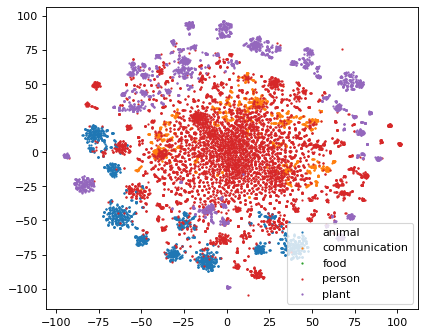

In [19]:
plt.figure(figsize=(6, 5), dpi=80)
for i, c, label in zip(label_ids, colors, labels):    
    plt.scatter(X_2d[pred_hdbscan == i, 0], X_2d[pred_hdbscan == i, 1], c=c, label=label, s=1)
    
plt.legend()    
plt.savefig('./Experiments/WN18RR/Figures/wn18RR-rotatE-hdbscan.png', dpi=600,  bbox_inches='tight',pad_inches=0)
plt.show()

## Method 2) K-means

In [16]:
%%time
kmeans = KMeans(n_clusters=len(top_types), random_state=42).fit(X_all)
pred_kmeans = kmeans.predict(X_all)

# majority voting per cluster
df_tmp = pd.DataFrame({'pred_kmeans': pred_kmeans, 'y_all': y_all})
pred_kmeans = df_tmp.groupby('pred_kmeans').transform(lambda x: x.mode().iloc[0]).to_numpy().reshape(-1)

CPU times: user 27.9 s, sys: 994 ms, total: 28.9 s
Wall time: 2.01 s


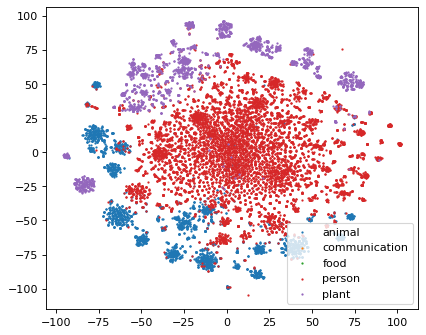

In [18]:
plt.figure(figsize=(6, 5), dpi=80)
for i, c, label in zip(label_ids, colors, labels):    
    plt.scatter(X_2d[pred_kmeans == i, 0], X_2d[pred_kmeans == i, 1], c=c, label=label, s=1)
    
plt.legend()    
plt.savefig('./Experiments/WN18RR/Figures/wn18RR-rotatE-Kmeans.png', dpi=600,  bbox_inches='tight',pad_inches=0)
plt.show()

In [23]:
accuracy = accuracy_score(y_all, pred_kmeans)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_all, pred_kmeans, zero_division=0, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_all, pred_kmeans, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_all, pred_kmeans, average='weighted')
print('F1 score: %f' % f1)

print ('Purity: ' , evaluator.purity_score(y_true=y_all, y_pred=pred_kmeans))

Accuracy: 0.594494
Precision: 0.592967
Recall: 0.594494
F1 score: 0.547447
Purity:  0.594493999871655


## Method 3) Agglomerative Clustering

In [20]:
%%time
aggClustering = AgglomerativeClustering(n_clusters=len(top_types))
y_aggClustering=aggClustering.fit_predict(X_all)

# majority voting per cluster
df_tmp = pd.DataFrame({'pred_agglom': y_aggClustering, 'y_all': y_all})
pred_agglom = df_tmp.groupby('pred_agglom').transform(lambda x: x.mode().iloc[0]).to_numpy().reshape(-1)

CPU times: user 37.7 s, sys: 733 ms, total: 38.4 s
Wall time: 38.4 s


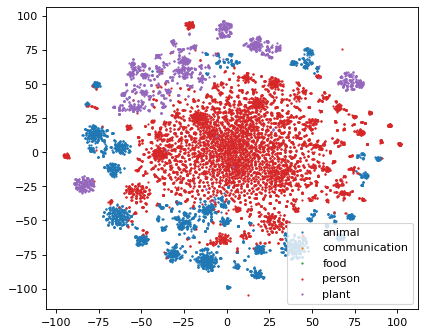

In [21]:
plt.figure(figsize=(6, 5), dpi=80)
for i, c, label in zip(label_ids, colors, labels):    
    plt.scatter(X_2d[pred_agglom == i, 0], X_2d[pred_agglom == i, 1], c=c, label=label, s=1)
    
plt.legend()    
plt.savefig('./Experiments/WN18RR/Figures/wn18RR-rotatE-agglom.png', dpi=600,  bbox_inches='tight',pad_inches=0)
plt.show()

In [22]:
accuracy = accuracy_score(y_all, pred_agglom)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_all, pred_agglom, zero_division=0, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_all, pred_agglom, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_all, pred_agglom, average='weighted')
print('F1 score: %f' % f1)

print ('Purity: ' , evaluator.purity_score(y_true=y_all, y_pred=pred_agglom))

Accuracy: 0.569852
Precision: 0.555260
Recall: 0.569852
F1 score: 0.514232
Purity:  0.569851761535006


# Supervised Baselines:

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.33, random_state=42)

In [24]:
projection_train = TSNE(random_state=42).fit_transform(X_train)
projection_test = TSNE(random_state=42).fit_transform(X_test)

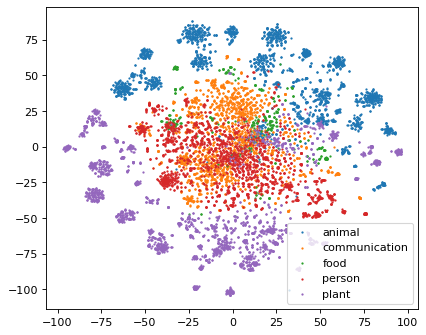

In [25]:
plt.figure(figsize=(6, 5), dpi=80)
for i, c, label in zip(label_ids, colors, labels):    
    plt.scatter(projection_train[y_train == i, 0], projection_train[y_train == i, 1], c=c, label=label, s=1)
    
plt.legend()    
plt.savefig('./Experiments/WN18RR/Figures/wn18RR-rotatE-train.png', dpi=600,  bbox_inches='tight',pad_inches=0)
plt.show()

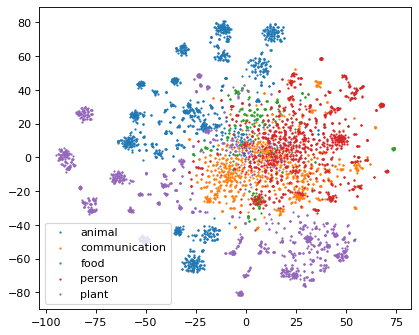

In [26]:
plt.figure(figsize=(6, 5), dpi=80)
for i, c, label in zip(label_ids, colors, labels):    
    plt.scatter(projection_test[y_test == i, 0], projection_test[y_test == i, 1], c=c, label=label, s=1)
    
plt.legend()    
plt.savefig('./Experiments/WN18RR/Figures/wn18RR-rotatE-test.png', dpi=600,  bbox_inches='tight',pad_inches=0)
plt.show()

## Method 1) Logistic Regression

In [27]:
%%time
from sklearn.linear_model import LogisticRegression

logistic_clf = LogisticRegression(solver='liblinear',random_state=42).fit(X_train, y_train.ravel())
y_lr = logistic_clf.predict(X_test)


CPU times: user 1.82 s, sys: 68 ms, total: 1.89 s
Wall time: 1.83 s


In [28]:
#----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_test, y_lr)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_test, y_lr, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_test, y_lr, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_test, y_lr, average='weighted')
print('F1 score: %f' % f1)

print('Purity Score: ', evaluator.purity_score(y_true=y_test, y_pred=y_lr))

Accuracy: 0.853199
Precision: 0.854520
Recall: 0.853199
F1 score: 0.851800
Purity Score:  0.8531985222632704


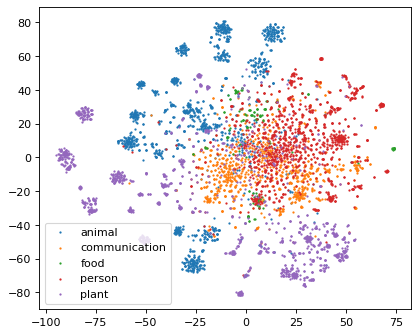

In [29]:
plt.figure(figsize=(6, 5), dpi=80)
for i, c, label in zip(label_ids, colors, labels):    
    plt.scatter(projection_test[y_lr == i, 0], projection_test[y_lr == i, 1], c=c, label=label, s=1)
    
plt.legend()    
plt.savefig('./Experiments/WN18RR/Figures/wn18RR-rotatE-y_lr.png', dpi=600,  bbox_inches='tight',pad_inches=0)
plt.show()

## Method 2) KNN

In [30]:
%%time
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train.ravel())
y_knn = neigh.predict(X_test)


CPU times: user 29 s, sys: 0 ns, total: 29 s
Wall time: 29 s


In [31]:
#----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_test, y_knn)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_test, y_knn, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_test, y_knn, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_test, y_knn, average='weighted')
print('F1 score: %f' % f1)

print('Purity Score: ', evaluator.purity_score(y_true=y_test, y_pred=y_knn))

Accuracy: 0.938363
Precision: 0.938523
Recall: 0.938363
F1 score: 0.938355
Purity Score:  0.9383628232549096


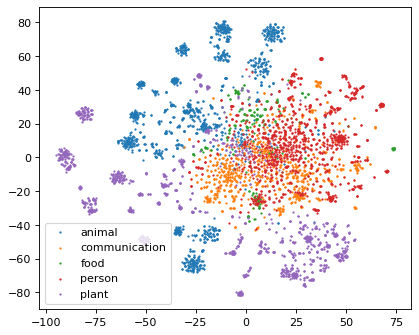

In [35]:
plt.figure(figsize=(6, 5), dpi=80)
for i, c, label in zip(label_ids, colors, labels):    
    plt.scatter(projection_test[y_knn == i, 0], projection_test[y_knn == i, 1], c=c, label=label, s=1)
    
plt.legend()    
plt.savefig('./Experiments/WN18RR/Figures/wn18RR-rotatE-y_knn.png', dpi=600,  bbox_inches='tight',pad_inches=0)
plt.show()

## Method 3) RandomForest

In [33]:
%%time
from sklearn.ensemble import RandomForestClassifier

random_clf = RandomForestClassifier(random_state=42).fit(X_train, y_train.ravel())
y_rf= random_clf.predict(X_test)

CPU times: user 16.6 s, sys: 0 ns, total: 16.6 s
Wall time: 16.7 s


In [34]:
#----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_test, y_rf)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_test, y_rf, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_test, y_rf, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_test, y_rf, average='weighted')
print('F1 score: %f' % f1)

print('Purity Score: ', evaluator.purity_score(y_true=y_test, y_pred=y_rf))

Accuracy: 0.927085
Precision: 0.930203
Recall: 0.927085
F1 score: 0.924606
Purity Score:  0.927085358740035


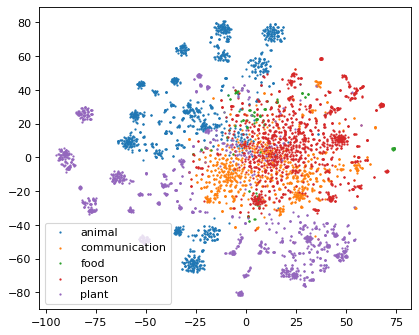

In [36]:
plt.figure(figsize=(6, 5), dpi=80)
for i, c, label in zip(label_ids, colors, labels):    
    plt.scatter(projection_test[y_rf == i, 0], projection_test[y_rf == i, 1], c=c, label=label, s=1)
    
plt.legend()    
plt.savefig('./Experiments/WN18RR/Figures/wn18RR-rotatE-rf.png', dpi=600,  bbox_inches='tight',pad_inches=0)
plt.show()

# Random Clustering Baselines:

## Method 1) Uniformly:

In [37]:
y_random=np.random.choice(list(range(0, len(top_types))), size=y_all.shape[0])
# majority voting per cluster
df_tmp = pd.DataFrame({'y_random': y_random, 'y_all': y_all})
y_random = df_tmp.groupby('y_random').transform(lambda x: x.mode().iloc[0]).to_numpy().reshape(-1)

In [38]:
#----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_all, y_random)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_all, y_random, zero_division=0,average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_all, y_random, zero_division=0,average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_all, y_random, zero_division=0,average='weighted')
print('F1 score: %f' % f1)
print ('Purity: ' , evaluator.purity_score(y_true=y_all, y_pred=y_random))

Accuracy: 0.275172
Precision: 0.145384
Recall: 0.275172
F1 score: 0.173291
Purity:  0.2751716614259129


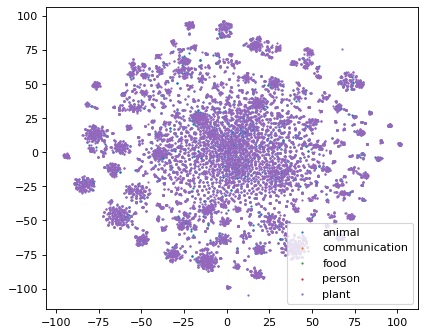

In [39]:
plt.figure(figsize=(6, 5), dpi=80)
for i, c, label in zip(label_ids, colors, labels):    
    plt.scatter(X_2d[y_random == i, 0], X_2d[y_random == i, 1], c=c, label=label, s=1)
    
plt.legend()    
plt.savefig('./Experiments/WN18RR/Figures/wn18RR-rotatE-random_uniformly.png', dpi=600,  bbox_inches='tight',pad_inches=0)
plt.show()


## Method 2) By Class Distribution

In [40]:
weights=[]
y_counts=Counter(y_all)

for i in range(len(top_types)):
    weights.append(y_counts[i]/y_all.shape[0])
    
weights    

[0.2581659500737984,
 0.1877045498299429,
 0.04344477956747738,
 0.23653981903356222,
 0.27414490149521914]

In [41]:
y_random_bala=np.random.choice(list(range(0, len(top_types))), size=y_all.shape[0], p=weights)
# majority voting per cluster
df_tmp = pd.DataFrame({'y_random_bala': y_random_bala, 'y_all': y_all})
y_random_bala = df_tmp.groupby('y_random_bala').transform(lambda x: x.mode().iloc[0]).to_numpy().reshape(-1)

In [42]:
#----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_all, y_random_bala)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_all, y_random_bala, zero_division=0,average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_all, y_random_bala, zero_division=0,average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_all, y_random_bala, zero_division=0,average='weighted')
print('F1 score: %f' % f1)
print ('Purity: ' , evaluator.purity_score(y_true=y_all, y_pred=y_random_bala))

Accuracy: 0.275813
Precision: 0.207090
Recall: 0.275813
F1 score: 0.198847
Purity:  0.2758133863825964


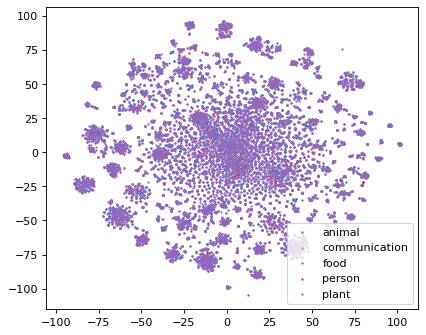

In [43]:
plt.figure(figsize=(6, 5), dpi=80)
for i, c, label in zip(label_ids, colors, labels):    
    plt.scatter(X_2d[y_random_bala == i, 0], X_2d[y_random_bala == i, 1], c=c, label=label, s=1)
    
plt.legend()    
plt.savefig('./Experiments/WN18RR/Figures/wn18RR-rotatE-random_classDist.png', dpi=600,  bbox_inches='tight',pad_inches=0)
plt.show()
